<a href="https://colab.research.google.com/github/GymYJ/RNN_time-series/blob/master/rnn_smp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import os
import datetime as dt

tf.set_random_seed(777)  # reproducibility

def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator)


# train hyperParameters
seq_length = 7
data_dim = 24
hidden_dim = 595
output_dim = 24
learning_rate = 0.006
iterations = 120

# Open, Close
f = open('/content/gdrive/My Drive/Colab Notebooks/smp_land_2019.csv', 'rt', encoding='UTF8')
for i in range(4): f.readline() # 설명, 인덱스 부분 날리기
lines = f.readlines()
data = []
datetime = 0
for line in lines:
    data.append(line.strip('\n').split(',')[1:-3])
    datetime = line.split(',')[0]
data.append([100]*24)
xy = np.array(data).astype(np.float)
f.close()

# train/test split
train_size = int(len(xy)*0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

datetime = int(datetime)
Year = datetime // 10000
Month = (datetime % 10000) // 100
Day = datetime % 100
datetime = dt.date(Year, Month, Day)
datetime = datetime + dt.timedelta(days=1)
datetime = str(datetime.year) + str(datetime.month) + str(datetime.day)

print(datetime)
print(len(xy))
print(len(train_set))
print(len(test_set))
train_set.shape

20191228
362
253
116


(253, 24)

In [16]:

# Scale each
save_train = train_set
save_test = test_set
train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)

# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, :]
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

print("build datasets done")


build datasets done


In [0]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience  = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print(f'Training process is stopped early....')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [18]:
step = 0
while step < 100:
    
    tf.reset_default_graph()
    # input place holders
    X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
    Y = tf.placeholder(tf.float32, [None, 24])

    # build a LSTM network
    cell = tf.contrib.rnn.BasicLSTMCell(
        num_units=hidden_dim, state_is_tuple=True, activation=tf.nn.tanh)
    outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    Y_pred = tf.contrib.layers.fully_connected(
        outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

    # cost/loss
    loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
    # optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(loss)

    # RMSE
    targets = tf.placeholder(tf.float32, [None, 24])
    predictions = tf.placeholder(tf.float32, [None, 24])
    rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)

        early_stopping = EarlyStopping(patience=20, verbose=1)
        saver = tf.train.Saver()
        # Training step
        step = 0
        for i in range(iterations):
            _, step_loss = sess.run([train, loss], feed_dict={
                                    X: trainX, Y: trainY})
            test_predict = sess.run(Y_pred, feed_dict={X: testX})
            rmse_val = sess.run(rmse, feed_dict={
                targets: testY, predictions: test_predict})
            print("[step: {}] train_loss: {} \t test_RMSE: {}".format(i, step_loss, rmse_val))
            step += 1
            if early_stopping.validate(rmse_val):
                break
            
        saver.save(sess, save_path='/content/gdrive/My Drive/Colab Notebooks/lstm.model')
        # Test step
        


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `layer.__call__` method instead.
[step: 0] train_loss: 2179.1015625 	 test_RMSE: 1.2296664714813232
[step: 1] train_loss: 11007.5556640625 	 test_RMSE: 0.6512947678565979
[step: 2] t

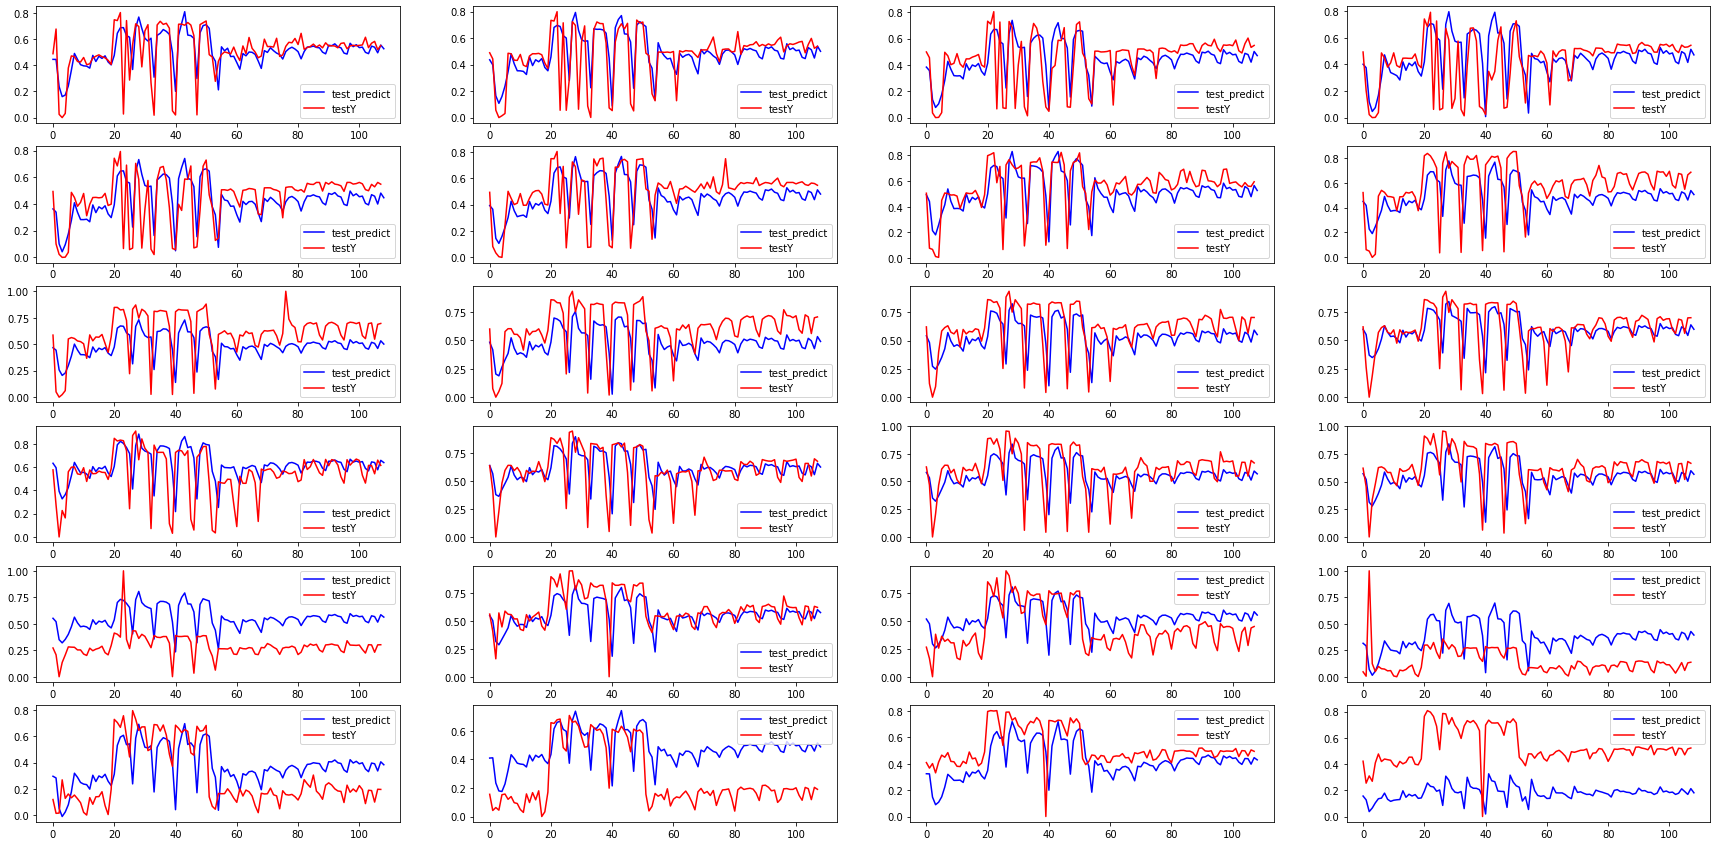

In [19]:
import matplotlib.pyplot as plt

# Plot predictions
plt.figure(figsize=(30, 15))
#test_predict = MinMaxScaler(test_predict) # predict 값 0~1로 맞추기
for i in range(24):
    plt.subplot(6,4,i+1)
    plt.plot(test_predict[:,i], c='blue', label='test_predict')
    plt.plot(testY[:-1,i], c='red', label='testY')
    plt.legend()
plt.show()

In [0]:
def invertMinMaxScaler(data, scale):
    denominator = np.max(data, 0) - np.min(data, 0)
    return (scale * (denominator)) + np.min(data, 0)

In [33]:
invertPredict = invertMinMaxScaler(save_test, test_predict)
invertReal = invertMinMaxScaler(save_test, test_set)
invertValue = []
print("scaled value\n")
for i in range(24):
    print("[%d h] - scaled: %f invert scaled: %f" % (i+1, test_predict[-1,i], invertPredict[-1,i]))
    invertValue.append(float(invertPredict[-1,i]))

scaled value

[1 h] - scaled: 0.525157 invert scaled: 80.939794
[2 h] - scaled: 0.500565 invert scaled: 79.118617
[3 h] - scaled: 0.470416 invert scaled: 77.407953
[4 h] - scaled: 0.472062 invert scaled: 77.478182
[5 h] - scaled: 0.446305 invert scaled: 76.379363
[6 h] - scaled: 0.480459 invert scaled: 77.872762
[7 h] - scaled: 0.526442 invert scaled: 79.963753
[8 h] - scaled: 0.504698 invert scaled: 79.692600
[9 h] - scaled: 0.501151 invert scaled: 79.617675
[10 h] - scaled: 0.491307 invert scaled: 78.507700
[11 h] - scaled: 0.552247 invert scaled: 80.831696
[12 h] - scaled: 0.598514 invert scaled: 82.812378
[13 h] - scaled: 0.637956 invert scaled: 84.500900
[14 h] - scaled: 0.624309 invert scaled: 83.916648
[15 h] - scaled: 0.568967 invert scaled: 82.030214
[16 h] - scaled: 0.565834 invert scaled: 82.381550
[17 h] - scaled: 0.562974 invert scaled: 109.024735
[18 h] - scaled: 0.576000 invert scaled: 85.104896
[19 h] - scaled: 0.553918 invert scaled: 89.182512
[20 h] - scaled: 0.393468

In [23]:
!pip install PyMySQL

     |████████████████████████████████| 51kB 2.7MB/s 


In [0]:
import pymysql.cursors

connection = pymysql.connect(host = ,
                             user = ,
                             password = ,
                             db = ,
                             charset = 'utf8mb4',
                             cursorclass = pymysql.cursors.DictCursor)

try:
    with connection.cursor() as cursor:
        sql = """
            INSERT INTO SMP_PRED (SMP_YMD, t_1H, t_2H, t_3H, t_4H, t_5H, t_6H, 
            t_7H, t_8H, t_9H, t_10H, t_11H, t_12H, t_13H, t_14H, t_15H, t_16H, 
            t_17H, t_18H, t_19H, t_20H, t_21H, t_22H, t_23H, t_24H) 
            VALUES (%s, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f)
            """
        cursor.execute(sql % (datetime, invertValue[0], invertValue[1], invertValue[2], invertValue[3], invertValue[4], invertValue[5]
                             , invertValue[6], invertValue[7], invertValue[8], invertValue[9], invertValue[10], invertValue[11]
                             , invertValue[12], invertValue[13], invertValue[14], invertValue[15], invertValue[16], invertValue[17]
                             , invertValue[18], invertValue[19], invertValue[20], invertValue[21], invertValue[22], invertValue[23]))
        connection.commit()
finally:
    connection.close()